In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, confusion_matrix


# Loading data
cpi = pd.read_csv(
    "cpi_data_formatted.csv", 
    infer_datetime_format=True,
    parse_dates=True
)


# Loading data
#cpi_file = r'CPI Data - Sheet1.csv'
#cpi = pd.read_csv(cpi_file)

# Convert 'DATE' to datetime
cpi['DATE'] = pd.to_datetime(cpi['DATE'], errors='coerce')

# Extract timestamp as a numerical representation of the date
#cpi['Timestamp'] = (cpi['DATE'] - pd.Timestamp("1960-01-01")) // pd.Timedelta('1D')
# Convert date to a float representation (e.g., YYYYMMDD)
#cpi['date_as_float'] = cpi['DATE'].apply(lambda x: float(x.strftime('%Y%m%d')) if pd.notnull(x) else x)

# Get dummies and encode 'President' columns as 0 and 1
df_encoded = pd.get_dummies(cpi, columns=['President'])
df_encoded = df_encoded.set_index("DATE")
# Convert boolean values to integers (0 and 1)
df_encoded[['President_Dem', 'President_Rep']] = df_encoded[['President_Democrat', 'President_Republican']].astype(int)

# Drop the original 'President' columns
#df_encoded = df_encoded.drop(['President_Democrat', 'President_Republican', 'DATE'], axis=1)
df_encoded = df_encoded.drop(['President_Democrat', 'President_Republican'], axis=1)

C:\Users\tlsul\AppData\Local\Temp\ipykernel_9968\2955611224.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  cpi = pd.read_csv(


In [2]:
df_encoded

,Crude,natural_gas,Cocoa,Coffee,Soybeans,soybean_oil,soybean_meal,Maize,Wheat,Banana,...,Cotton,Rubber,Phosphate,Aluminum,Iron ore,Copper,Gold,CPI,President_Dem,President_Rep
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,1.63,0.14,0.63,0.94,94.00,204.00,91.90,45.00,59.89,0.14,...,0.65,0.82,13.00,511.47,11.42,715.40,35.27,29.370,0,1
1960-02-01,1.63,0.14,0.61,0.95,91.00,201.00,86.70,44.00,60.99,0.14,...,0.65,0.83,13.00,511.47,11.42,728.19,35.27,29.410,0,1
1960-03-01,1.63,0.14,0.58,0.93,92.00,201.00,84.10,45.00,61.73,0.14,...,0.65,0.86,13.00,511.47,11.42,684.94,35.27,29.410,0,1
1960-04-01,1.63,0.14,0.60,0.93,93.00,207.00,86.70,45.00,60.99,0.14,...,0.64,0.86,13.00,511.47,11.42,723.11,35.27,29.540,0,1
1960-05-01,1.63,0.14,0.60,0.92,93.00,209.00,81.50,48.00,57.69,0.15,...,0.65,0.93,13.00,511.47,11.42,684.75,35.27,29.570,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,78.98,2.55,3.39,4.27,633.85,1135.74,517.23,242.38,345.50,1.55,...,2.05,1.49,342.50,2159.73,114.43,8476.68,1951.02,304.348,1,0
2023-08-01,84.72,2.58,3.46,4.12,583.93,1126.53,514.56,207.61,315.82,1.56,...,2.11,1.47,346.25,2136.57,110.20,8349.13,1918.70,306.269,1,0
2023-09-01,92.22,2.64,3.61,4.05,619.04,1111.63,509.31,223.81,314.68,1.56,...,2.16,1.55,347.50,2184.67,120.98,8276.71,1915.95,307.481,1,0


In [3]:
features = df_encoded[[
     'Crude', 'natural_gas', 'Cocoa', 'Coffee', 'Soybeans', 'soybean_oil',
    'soybean_meal', 'Maize', 'Wheat', 'Banana', 'Orange', 'Beef', 'Chicken',
    'Sugar', 'Cotton', 'Rubber', 'Phosphate', 'Aluminum', 'Iron ore', 'Copper',
    'Gold', 'President_Dem','President_Rep']]
#.astype(float)

target_variable = df_encoded['CPI']

In [4]:

target = target_variable


training_features, testing_features, training_target, testing_target = \
            train_test_split(features, target, random_state=42)

# Average CV score on the training set was: -3.7106600813535024
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    StackingEstimator(estimator=RidgeCV()),
    ExtraTreesRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=3, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)



In [ ]:
# Evaluate the model on the test set
test_score = exported_pipeline.score(testing_features, testing_target)
print(f'Test Score: {test_score}')

In [5]:
results_df = pd.DataFrame({'Actual': testing_target, 'Predicted': results})

results_df = results_df.sort_index(ascending=True)  # Sort by the new index

# Print the first few rows of the DataFrame
print(results_df)

             Actual   Predicted
DATE                           
1960-03-01   29.410   29.533983
1960-07-01   29.550   29.609850
1960-08-01   29.610   29.650200
1960-11-01   29.780   29.754417
1961-12-01   30.010   29.948150
...             ...         ...
2022-01-01  282.599  276.310273
2022-04-01  288.611  291.282263
2022-10-01  297.987  297.123945
2023-07-01  304.348  299.651702
2023-08-01  306.269  302.282032

[192 rows x 2 columns]


<Axes: title={'center': 'CPI Actual vs Predicted Extra Tree Regressor'}, xlabel='DATE', ylabel='CPI in bps'>

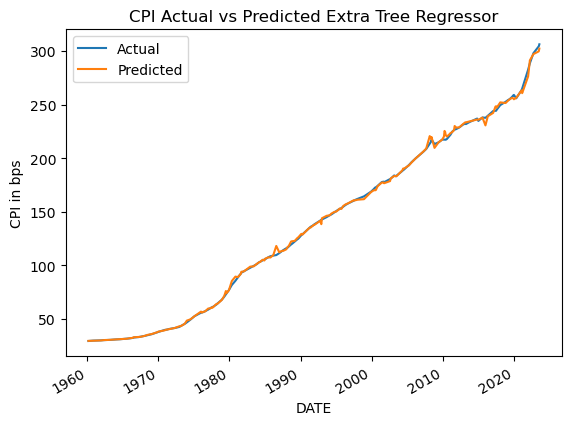

In [6]:
results_df.plot(title = 'CPI Actual vs Predicted Extra Tree Regressor', ylabel = 'CPI in bps' )

In [7]:
# Assuming you have trained your model and have predictions
y_true = testing_target  # True target values
y_pred = results  # Predicted values from the model

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
evs = explained_variance_score(y_true, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Explained Variance Score:", evs)


Mean Squared Error: 3.5600757037496717
Mean Absolute Error: 1.05184140190973
R-squared: 0.999437022147395
Explained Variance Score: 0.9994450666916135


In [8]:
future_cpi_predict_features = pd.read_csv(
    "cpi_data_formatted_ten_years_out.csv", 
    infer_datetime_format=True,
    parse_dates=True
)

C:\Users\tlsul\AppData\Local\Temp\ipykernel_9968\2824214084.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  future_cpi_predict_features = pd.read_csv(


In [9]:
# Convert 'DATE' to datetime
future_cpi_predict_features['DATE'] = pd.to_datetime(future_cpi_predict_features['DATE'], errors='coerce')
future_cpi_predict_features_df_encoded = future_cpi_predict_features.set_index("DATE")

In [10]:
future_cpi_predict_features

,DATE,Crude,natural_gas,Cocoa,Coffee,Soybeans,soybean_oil,soybean_meal,Maize,Wheat,...,Cotton,Rubber,Phosphate,Aluminum,Iron ore,Copper,Gold,President,CPI,Unnamed: 24
0,1960-01-01,1.630000,0.140000,0.630000,0.940000,94.000000,204.000000,91.900000,45.000000,59.890000,...,0.650000,0.820000,13.000000,511.470000,11.420000,715.40000,35.270000,Republican,29.370000,NaN
1,1960-02-01,1.630000,0.140000,0.610000,0.950000,91.000000,201.000000,86.700000,44.000000,60.990000,...,0.650000,0.830000,13.000000,511.470000,11.420000,728.19000,35.270000,Republican,29.410000,NaN
2,1960-03-01,1.630000,0.140000,0.580000,0.930000,92.000000,201.000000,84.100000,45.000000,61.730000,...,0.650000,0.860000,13.000000,511.470000,11.420000,684.94000,35.270000,Republican,29.410000,NaN
3,1960-04-01,1.630000,0.140000,0.600000,0.930000,93.000000,207.000000,86.700000,45.000000,60.990000,...,0.640000,0.860000,13.000000,511.470000,11.420000,723.11000,35.270000,Republican,29.540000,NaN
4,1960-05-01,1.630000,0.140000,0.600000,0.920000,93.000000,209.000000,81.500000,48.000000,57.690000,...,0.650000,0.930000,13.000000,511.470000,11.420000,684.75000,35.270000,Republican,29.570000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2033-09-01,103.561977,3.449944,5.130360,5.537733,704.055945,1423.757578,727.683607,268.942879,360.971093,...,2.533354,2.125980,442.382137,2803.569742,166.857631,10425.69302,8063.680811,Democrat,391.991311,NaN
885,2033-10-01,103.820881,3.458569,5.143186,5.551578,705.816085,1427.316972,729.502816,269.615236,361.873521,...,2.539687,2.131295,443.488092,2810.578666,167.274775,10451.75726,8083.840013,Democrat,392.971289,NaN
886,2033-11-01,104.080434,3.467215,5.156044,5.565457,707.580625,1430.885264,731.326573,270.289274,362.778205,...,2.546036,2.136624,444.596813,2817.605113,167.692962,10477.88665,8104.049613,Democrat,393.953717,NaN
887,2033-12-01,104.340635,3.475883,5.168934,5.579370,709.349577,1434.462478,733.154889,270.964997,363.685151,...,2.552402,2.141965,445.708305,2824.649125,168.112194,10504.08137,8124.309737,Republican,394.938602,NaN


In [14]:
# Get dummies and encode 'President' columns as 0 and 1
future_cpi_predict_features_df_encoded = pd.get_dummies(future_cpi_predict_features, columns=['President'])

# Convert boolean values to integers (0 and 1)
future_cpi_predict_features_df_encoded[['President_Dem', 'President_Rep']] = future_cpi_predict_features_df_encoded[['President_Democrat', 'President_Republican']].astype(int)

# Drop the original 'President' columns
future_cpi_predict_features_df_encoded = future_cpi_predict_features_df_encoded.drop(['President_Democrat', 'President_Republican','CPI','Unnamed: 24'], axis=1)

In [15]:
future_cpi_predict_features_df_encoded =future_cpi_predict_features_df_encoded.set_index('DATE')

In [16]:
cpi_predict_result = exported_pipeline.predict(future_cpi_predict_features_df_encoded)

In [25]:
cpi_predict_result_ten_year = pd.DataFrame(cpi_predict_result, columns=['CPI Forecast'])
cpi_predict_result_ten_year['Date'] = future_cpi_predict_features_df_encoded.index
cpi_predict_result_ten_year['Date'] = pd.to_datetime(cpi_predict_result_ten_year['Date'], errors='coerce')
cpi_predict_result_ten_year =cpi_predict_result_ten_year.set_index('Date')

In [26]:
cpi_predict_result_ten_year = cpi_predict_result_ten_year.sort_index(ascending=True)  # Sort by the new index

In [27]:
cpi_predict_result_ten_year

,CPI Forecast
Date,
1960-01-01,29.406700
1960-02-01,29.406700
1960-03-01,29.533983
1960-04-01,29.525700
1960-05-01,29.601933
...,...
2033-09-01,298.274877
2033-10-01,298.274877
2033-11-01,298.274877


<Axes: title={'center': 'CPI Predicted with 2% Annual Inflation'}, xlabel='Date', ylabel='CPI in bps'>

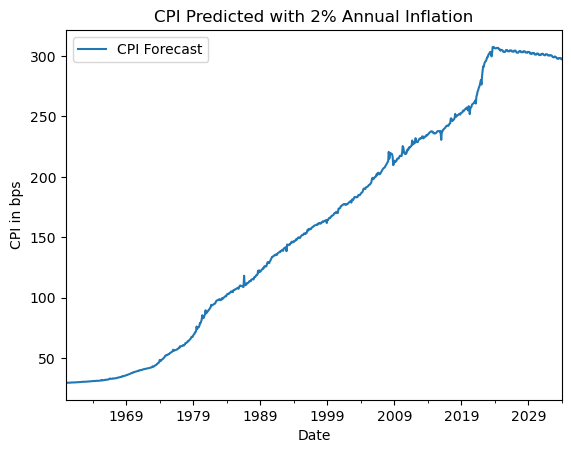

In [28]:
cpi_predict_result_ten_year.plot(title = 'CPI Predicted with 2% Annual Inflation', ylabel = 'CPI in bps' )


<Axes: xlabel='Date'>

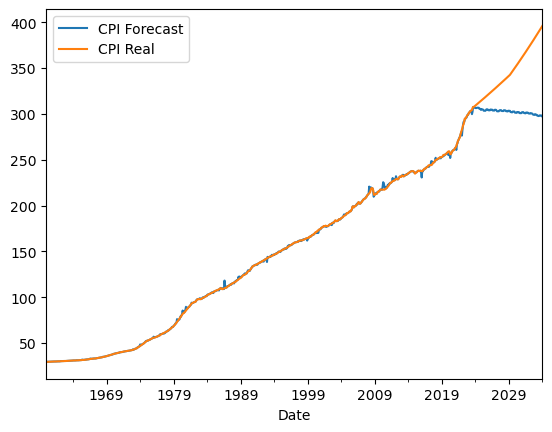

In [42]:
joint = pd.DataFrame(cpi_predict_result, columns=['CPI Forecast'])
joint['CPI Real'] = future_cpi_predict_features['CPI']
joint['Date'] = future_cpi_predict_features['DATE']

joint = joint.set_index('Date')

joint.plot()

<Axes: xlabel='Date'>

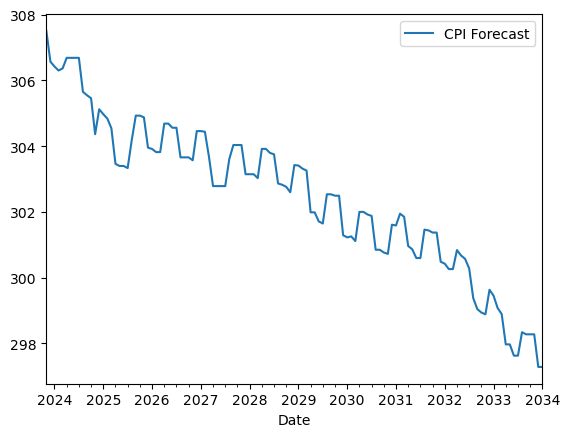

In [29]:
start_date = '2023-11-01'
end_date = '2034-1-01'  # Adjust as needed

cpi_predict_result_ten_year.loc[start_date:end_date].plot()

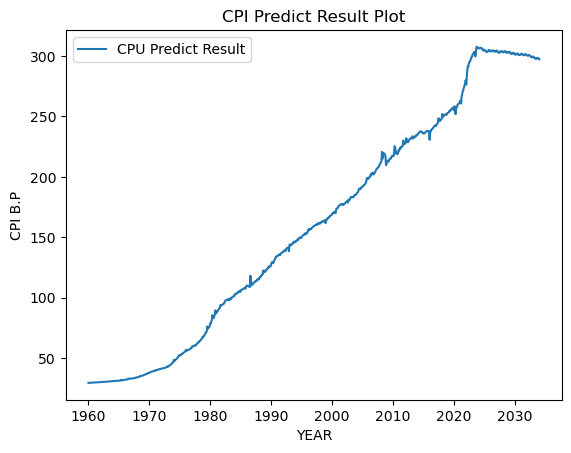

In [22]:
date_index = future_cpi_predict_features_df_encoded.index

x_values = np.arange(len(cpi_predict_result))
##### Create a figure and axis ####
fig, ax = plt.subplots()
### Ploting (<word?)  the data as a line plot ##
ax.plot(date_index, cpi_predict_result, label='CPU Predict Result')
### Add labels and title##
ax.set_xlabel('YEAR')
ax.set_ylabel('CPI B.P')
ax.set_title('CPI Predict Result Plot')
## Show a legend if you have multiple lines on the plot
ax.legend()
# Show the plot
plt.show()